### Susannah D'Arcy
# Rectifying Bias & Feature Selection

## Part 1: Pipelines: Rectifying Bias - Cross Validation
To try to rectify the bias I will be using the survival dataset from the previous notebook. In which L5 is our minority class.

To compare the 2 methods I will be running each method multiple times (reps) and then compare the performance at each rep, and the average performance. Using multiple reps will showcase the degree of instability of each method.

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

surv = pd.read_csv('survival.csv')
surv['Survived'] = 'GE5'
surv.loc[surv['Class']==2,'Survived']='L5'
surv.head(10)

,Age,Year,NNodes,Class,Survived
0,30,64,1,1,GE5
1,30,62,3,1,GE5
2,30,65,0,1,GE5
3,31,59,2,1,GE5
4,31,65,4,1,GE5
5,33,58,10,1,GE5
6,33,60,0,1,GE5
7,34,59,0,2,L5
8,34,66,9,2,L5
9,34,58,30,1,GE5


In [2]:
#Split for Data (X) and target/class (y)
y = surv.pop('Survived').values
y_class = surv.pop('Class').values
X = surv.values

print("Minority class : %d" % (Counter(y)['L5']))
print("Majority class : %d" % (Counter(y)['GE5']))
print("Minority percentage : %0.2f" % (Counter(y)['L5']/len(y)))

Minority class : 81
Majority class : 225
Minority percentage : 0.26


In [3]:
#Shuffle Data
print("Before Shuffle:")
print(X.shape, y.shape)
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=1)
print("After Shuffle:")
print(X.shape, y.shape)

Before Shuffle:
(306, 3) (306,)
After Shuffle:
(306, 3) (306,)


### Models

In [4]:
models = {}

from sklearn.neighbors import KNeighborsClassifier
models['kNN'] = KNeighborsClassifier(n_neighbors=3)

from sklearn.tree import DecisionTreeClassifier
models['decisionTree'] = DecisionTreeClassifier(criterion='entropy')

from sklearn.linear_model import LogisticRegression
models['logReg'] = LogisticRegression(max_iter=10000, solver = 'sag', random_state=24)

from sklearn.ensemble import GradientBoostingClassifier
models['gradBoost']  = GradientBoostingClassifier(random_state=24)

### Scoring / Evaluation

In [5]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

#Scoring methods used by cross validation, will be comparing Accuracy, F1-Score and confusion matrix results.
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]

def acc(y_true, y_pred): return accuracy_score(y_true, y_pred)
def f1(y_true, y_pred): return f1_score(y_true, y_pred, pos_label='L5')


scoring = {'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn),
           'acc': make_scorer(acc), 'f1': make_scorer(f1)}

#Reps Amount for Part 1: Please alter depending on computational time/preference. I used reps_1 = 100
reps_1 = 100

### Hold-out testing + Raw Data

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix



accuracy_raw = {}
f1_raw = {}
pred_raw = {}
test_pred_raw = {}
precision_raw = {}
recall_raw = {}

for i in range(reps_1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
    
    for m in models:
        #Train + Prediction Results
        model = models[m].fit(X_train, y_train)
        y_pred = model.predict(X_test)
        pred_count = Counter(y_pred)['L5']/len(y_pred)
        test_pred_count = Counter(y_test)['L5']/len(y_test)

        #Accuracy
        acc = accuracy_score(y_test, y_pred)

        #F-1 Score
        f1 = f1_score(y_test, y_pred, pos_label='L5')

        #Precision
        precision = (tp(y_test, y_pred)) / (tp(y_test, y_pred) + fp(y_test, y_pred))
        #Recall
        recall = (tp(y_test, y_pred)) / (tp(y_test, y_pred) + fn(y_test, y_pred))
        
        if i is 0:
            accuracy_raw[m] = [acc]
            f1_raw[m] = [f1]
            pred_raw[m] = [pred_count]
            test_pred_raw[m] = [test_pred_count]
            precision_raw[m] = [precision]
            recall_raw[m] = [recall]
        else:
            accuracy_raw[m].append(acc)
            f1_raw[m].append(f1)
            pred_raw[m].append(pred_count)
            test_pred_raw[m].append(test_pred_count)
            precision_raw[m].append(precision)
            recall_raw[m].append(recall)

C:\Users\darcy\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in longlong_scalars


### Hold-out testing + SMOTE

In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix



accuracy_ho = {}
f1_ho = {}
pred_ho = {}
test_pred_ho = {}
precision_ho = {}
recall_ho = {}

for i in range(reps_1):
    sm = SMOTE(random_state=i)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
    X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
    
    for m in models:
        #Train + Prediction Results
        model = models[m].fit(X_train_smote, y_train_smote)
        y_pred = model.predict(X_test)
        pred_count = Counter(y_pred)['L5']/len(y_pred)
        test_pred_count = Counter(y_test)['L5']/len(y_test)
        
        #Accuracy
        acc = accuracy_score(y_test, y_pred)

        #F-1 Score
        f1 = f1_score(y_test, y_pred, pos_label='L5')
        
        #Precision
        precision = (tp(y_test, y_pred)) / (tp(y_test, y_pred) + fp(y_test, y_pred))
        #Recall
        recall = (tp(y_test, y_pred)) / (tp(y_test, y_pred) + fn(y_test, y_pred))
        
        if i is 0:
            accuracy_ho[m] = [acc]
            f1_ho[m] = [f1]
            pred_ho[m] = [pred_count]
            test_pred_ho[m] = [test_pred_count]
            precision_ho[m] = [precision]
            recall_ho[m] = [recall]
        else:
            accuracy_ho[m].append(acc)
            f1_ho[m].append(f1)
            pred_ho[m].append(pred_count)
            test_pred_ho[m].append(test_pred_count)
            precision_ho[m].append(precision)
            recall_ho[m].append(recall)

### Pipeline with Cross Validation + SMOTE

In [8]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, ShuffleSplit


accuracy_xv = {}
f1_xv = {}
tp_xv = {}
pred_xv = {}
test_pred_xv = {}
precision_xv = {}
recall_xv = {}

for i in range(reps_1):
    for m in models:
        kf = ShuffleSplit(n_splits=10, test_size=0.3, random_state=i)
        sm = SMOTE(random_state=i)
        kNN_smote_pipe = Pipeline(steps=[
            ('smote', sm),
            ('model',  models[m])
        ])

        
        cv_results = cross_validate(kNN_smote_pipe, X, y, cv=kf, scoring=scoring, return_train_score=False, 
                                                                                verbose = 0, n_jobs = -1)
        
        pred = (cv_results['test_tp'].sum() + cv_results['test_fp'].sum()) / (cv_results['test_tp'].sum() 
                                                                              + cv_results['test_fp'].sum() 
                                                                              + cv_results['test_tn'].sum() 
                                                                              + cv_results['test_fn'].sum())
       
        precision = (cv_results['test_tp'].sum()) / (cv_results['test_tp'].sum() + cv_results['test_fp'].sum())
        
        recall = (cv_results['test_tp'].sum()) / (cv_results['test_tp'].sum() + cv_results['test_fn'].sum())
    
        test_pred_count = Counter(y)['L5']/len(y)
        
        if i is 0:
            accuracy_xv[m] = [cv_results['test_acc'].mean()]
            f1_xv[m] = [cv_results['test_f1'].mean()]
            pred_xv[m] = [pred]
            test_pred_xv[m] = [test_pred_count]
            precision_xv[m] = [precision]
            recall_xv[m] = [recall]
        else:
            accuracy_xv[m].append(cv_results['test_acc'].mean())
            f1_xv[m].append(cv_results['test_f1'].mean())
            pred_xv[m].append(pred)
            test_pred_xv[m].append(test_pred_count)
            precision_xv[m].append(precision)
            recall_xv[m].append(recall)

### Comparison

In [9]:
import statistics
for m in models:
    print(type(models[m]).__name__)
    print("\t{:20}: Pred: L5:{:.2f} Test: L5:{:.2f}\tAccuracy: {:.2f}\tF1-Score: {:.2f}\tPrecision: {:.2f}\tRecall: {:.2f}".format(
                                                'Raw Averages', 
                                                statistics.mean(pred_raw[m]),
                                                statistics.mean(test_pred_raw[m]),
                                                statistics.mean(accuracy_raw[m]),
                                                statistics.mean(f1_raw[m]),
                                                statistics.mean(precision_raw[m]),
                                                statistics.mean(recall_raw[m])))
    print("\t{:20}: Pred: L5:{:.2f} Test: L5:{:.2f}\tAccuracy: {:.2f}\tF1-Score: {:.2f}\tPrecision: {:.2f}\tRecall: {:.2f}".format(
                                                'Hold Out Averages', 
                                                statistics.mean(pred_ho[m]),
                                                statistics.mean(test_pred_ho[m]),
                                                statistics.mean(accuracy_ho[m]),
                                                statistics.mean(f1_ho[m]),
                                                statistics.mean(precision_ho[m]),
                                                statistics.mean(recall_ho[m])))
    print("\t{:20}: Pred: L5:{:.2f} Test: L5:{:.2f}\tAccuracy: {:.2f}\tF1-Score: {:.2f}\tPrecision: {:.2f}\tRecall: {:.2f}".format(
                                                'Cross-Val Averages', 
                                                statistics.mean(pred_xv[m]),
                                                statistics.mean(test_pred_xv[m]),
                                                statistics.mean(accuracy_xv[m]),
                                                statistics.mean(f1_xv[m]),
                                                statistics.mean(precision_xv[m]),
                                                statistics.mean(recall_xv[m])))

KNeighborsClassifier
	Raw Averages        : Pred: L5:0.19 Test: L5:0.27	Accuracy: 0.70	F1-Score: 0.34	Precision: 0.43	Recall: 0.29
	Hold Out Averages   : Pred: L5:0.37 Test: L5:0.27	Accuracy: 0.63	F1-Score: 0.43	Precision: 0.38	Recall: 0.51
	Cross-Val Averages  : Pred: L5:0.37 Test: L5:0.26	Accuracy: 0.63	F1-Score: 0.42	Precision: 0.36	Recall: 0.51
DecisionTreeClassifier
	Raw Averages        : Pred: L5:0.27 Test: L5:0.27	Accuracy: 0.65	F1-Score: 0.34	Precision: 0.35	Recall: 0.35
	Hold Out Averages   : Pred: L5:0.33 Test: L5:0.27	Accuracy: 0.61	F1-Score: 0.36	Precision: 0.33	Recall: 0.40
	Cross-Val Averages  : Pred: L5:0.33 Test: L5:0.26	Accuracy: 0.63	F1-Score: 0.37	Precision: 0.34	Recall: 0.43
LogisticRegression
	Raw Averages        : Pred: L5:0.07 Test: L5:0.27	Accuracy: 0.74	F1-Score: 0.23	Precision: nan	Recall: 0.15
	Hold Out Averages   : Pred: L5:0.29 Test: L5:0.27	Accuracy: 0.72	F1-Score: 0.50	Precision: 0.49	Recall: 0.52
	Cross-Val Averages  : Pred: L5:0.29 Test: L5:0.26	Accurac

If we look at the raw classifiers (with no SMOTE up-sampling) we can see that its was under-classing the minority class (L5), even though it has a high accuracy. We can see that however, their is a poor precision and recall score represented by the F1-Score, which is a harmonic mean between the 2. 

For all models besides Decision Tree Classifier in the raw dataset had a higher precision than recall. Precision attempts to answer 'What proportion of positive identifications was actually correct?' while recall tries to answer 'What proportion of actual positives was identified correctly?'. This means that when the model classified a data point as the minority class, its was ~50% correct (approximately 0.5 precision), however only ~25% of the minority class was classified correctly as the minority class. This poor F1-Score is the result of the bias of the majority class, as due to the more data associated with the class the model is more likely to classify it. 

By looking at both of the Hold-Out and Cross Validation methods scores we can see that the up-sampling has worked and we are now classifying more of the minority class (L5). This improvement however seems to be at a cost of accuracy. The F1-scores have improved, by looking at the precision and recall we can see that we are now classifying more of the minority class correctly (recall). Although for some models such as k-NN and Gradient Boosting the precision has reduced. This could suggest that the SMOTE method has increase the noise in the dataset and such it has reduce the proportion of correctly identification of the minority class.   

By comparing the Pipeline Cross validation and Hold-out testing results we can see that on average there isn't much of a difference. However these average scores do not represent the stability of each evaluation method. The instability of these methods comes from the splitting mechanism. If the dataset has a lucky split the training set could be a much better dataset, and such create better performing models. However because we have averaged and flatten the performance we won't be able to see the affect of the lucky or unlucky split. Therefore we must look at the performance of each rep to fully evaluate the performance of each method. 

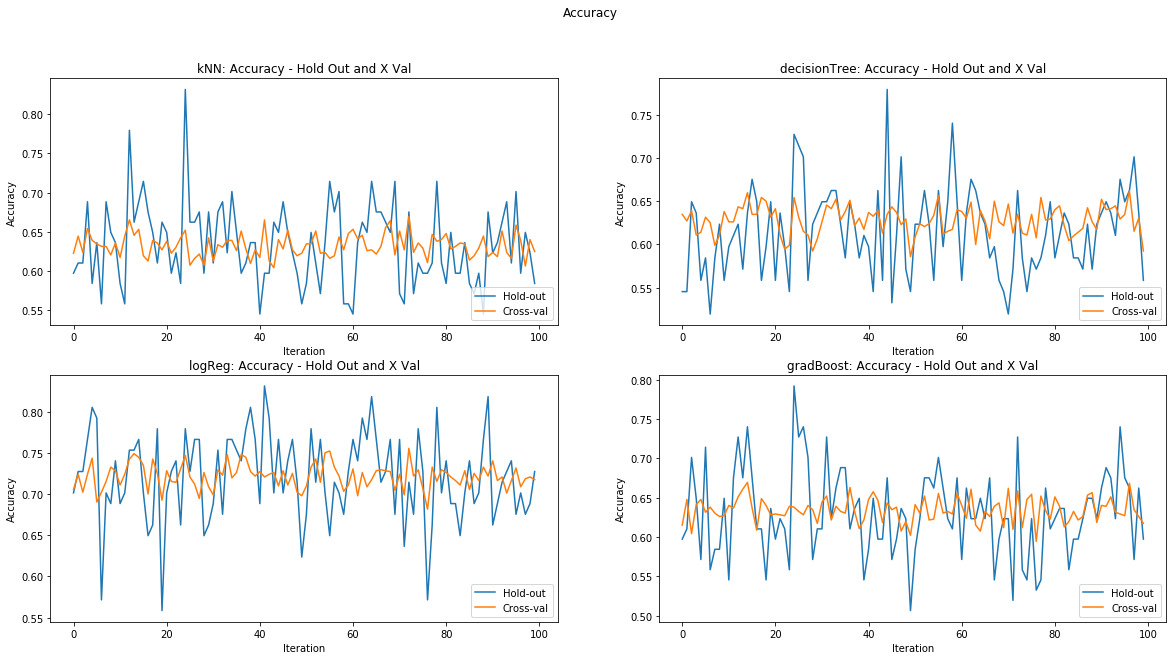

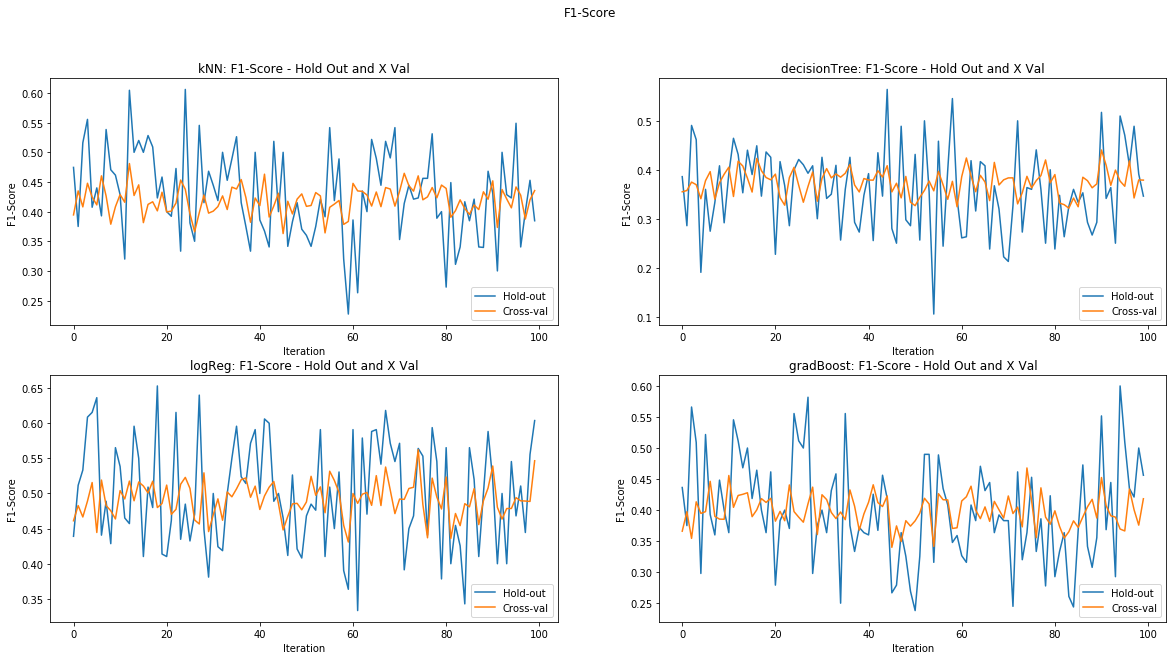

In [10]:
def printModelPerformanceComparison(method_ho, method_xv, methodName):
    fig, axs= plt.subplots(2, 2, figsize=(20,10))
    figs = [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]

    i=0;

    for m in models: 
        figs[i].plot(method_ho[m], label='Hold-out')
        figs[i].plot(method_xv[m], label='Cross-val')
        figs[i].legend(loc="lower right")
        figs[i].set_xlabel("Iteration")
        figs[i].set_ylabel(methodName)
        title = m + ": " + methodName + " - Hold Out and X Val"
        figs[i].set_title(title)
        i+=1
    
    fig.suptitle(methodName)
    plt.show()

    

printModelPerformanceComparison(accuracy_ho, accuracy_xv, 'Accuracy')
printModelPerformanceComparison(f1_ho, f1_xv, 'F1-Score')

By looking a the performance for each rep we can see the instability of hold-out testing. These charts show the impact of the random split method in hold-out testing, such that if you get a lucky split you will have a better performance. This shows that if you want a more stable method of testing your model cross validation is the better method. As it does a repeated splitting, which will lessen the dependence on the split. However we can see that the performance of cross validation has some variance aswell. Which means that this method doesn't eliminate the effect of the split.

In [11]:
print("Standard Deviation of Accuracy for Hold-out: %.3f" %(statistics.stdev(accuracy_ho['kNN'])))
print("Standard Deviation of Accuracy for Cross Validation: %.3f" %(statistics.stdev(accuracy_xv['kNN'])))

Standard Deviation of Accuracy for Hold-out: 0.051
Standard Deviation of Accuracy for Cross Validation: 0.014


By looking at the standard deviation of the scores we can see that Hold-out testing has nearly 5 times the amount of variance. Which suggest that is it nearly 5 times as unstable as cross validation. 

From looking at the charts you could suggest that an optimal method would be to take the best performing split, and use it for your model. However doing this could result in an over-fitting of the model, as this split could of been the best for that specific test data, therefore it could perform badly to unseen data. Due to this over-fitting issue I would still suggest that cross-validation is a better fitting method as it reduces over-fitting and is more stable. 

## Part 2: Feature Selection

To explore the impact of feature selection I will be using Backwards Sequential Elimination. This method is said to generate the best models as with backwards sequential searching it will be able to find the best subsets as it interacts with the whole dataset and features. However it is takes more computation power.

For finding the best feature set, you can either can the best feature subset of k features, where k is a predefined value. Or you can allow the method to find the best subset in a range of k features. For this assignment I will be using the second method as it will reduce the human interaction affecting the selection process (i.e by choosing the wrong/right value of k).

For exploring the performance of this feature selection method I will first do 1 run, and show the selection process. I will then repeat the selection, and take the most accurate subset for each rep, which will allow us to then compare the results its variation/instability.

In [12]:
gradBoost = GradientBoostingClassifier(random_state=0)
heart = pd.read_csv('heart-train.csv')
heart.head(10) 

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,60.0,0,253,0,35,0,279000.00,1.70,140,1,0,250,0
1,40.0,1,129,0,35,0,255000.00,0.90,137,1,0,209,0
2,86.0,0,582,0,38,0,263358.03,1.83,134,0,0,95,1
3,45.0,0,582,0,35,0,385000.00,1.00,145,1,0,61,1
4,72.0,0,127,1,50,1,218000.00,1.00,134,1,0,33,0
5,60.0,0,582,0,40,0,217000.00,3.70,134,1,0,96,1
6,61.0,1,84,0,40,1,229000.00,0.90,141,0,0,110,0
7,49.0,1,80,0,30,1,427000.00,1.00,138,0,0,12,0
8,45.0,0,582,0,20,1,126000.00,1.60,135,1,0,180,1
9,45.0,0,308,1,60,1,377000.00,1.00,136,1,0,186,0


In [13]:
#Split for Data (X) and target/class (y)
y = heart.pop('DEATH_EVENT').values
X = heart.values
print(X.shape, y.shape)
feature_names = heart.columns

(199, 12) (199,)


### Feature Selection 1 Rep
I have included showing the process and performance of 1 rep as it will allow us to see the relationship between accuracy and the number of features selected. 

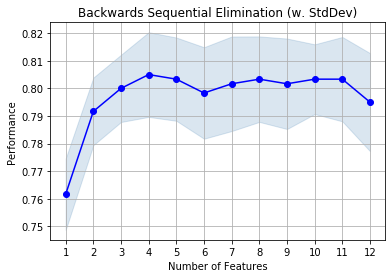

Best combination (ACC: 0.805): ('diabetes', 'platelets', 'serum_sodium', 'time')



In [14]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

kf = ShuffleSplit(n_splits=10, test_size=0.3, random_state=10)

# Sequential Backward Selection
sbs = SFS(gradBoost, 
          k_features=(1,12), 
          forward=False, 
          floating=False, 
          scoring='accuracy',
          cv=kf,
          n_jobs=-1)
sbs = sbs.fit(X, y, custom_feature_names=feature_names)

plot_sfs(sbs.get_metric_dict(), kind='std_err');
plt.title('Backwards Sequential Elimination (w. StdDev)')
plt.grid()
plt.show()

print('Best combination (ACC: %.3f): %s\n' % (sbs.k_score_, sbs.k_feature_names_))

From looking at the chart we can see that as we add more features the accuracy improves, however it starts to plateau at around 80% accuracy. It peaks at 80.5% with 4 features selected. The Sequential method used cross validation to test the performance of each feature subset, and such we choose the best average score. We also record the standard deviation of each cv score and such we are able to see in the chart the range of accuracies for different splits in the testing. This high std_dev shows again the instability of the evaluation methods. However by using cross validation we have reduce this instability 

We can also see the selection of each stage in a data-frame.

In [15]:
pd.DataFrame.from_dict(sbs.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
12,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)","[0.7833333333333333, 0.8166666666666667, 0.733...",0.795,"(age, anaemia, creatinine_phosphokinase, diabe...",0.0395533,0.0532552,0.0177517
11,"(0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11)","[0.7333333333333333, 0.7833333333333333, 0.766...",0.803333,"(age, anaemia, creatinine_phosphokinase, diabe...",0.0340354,0.0458258,0.0152753
10,"(0, 1, 2, 3, 5, 6, 8, 9, 10, 11)","[0.7666666666666667, 0.8, 0.7833333333333333, ...",0.803333,"(age, anaemia, creatinine_phosphokinase, diabe...",0.0281187,0.0378594,0.0126198
9,"(0, 1, 2, 3, 5, 6, 8, 10, 11)","[0.7333333333333333, 0.8, 0.7833333333333333, ...",0.801667,"(age, anaemia, creatinine_phosphokinase, diabe...",0.0364905,0.0491313,0.0163771
8,"(0, 1, 2, 3, 5, 6, 8, 11)","[0.7666666666666667, 0.8166666666666667, 0.783...",0.803333,"(age, anaemia, creatinine_phosphokinase, diabe...",0.0344826,0.046428,0.015476
7,"(0, 1, 3, 5, 6, 8, 11)","[0.75, 0.8166666666666667, 0.7666666666666667,...",0.801667,"(age, anaemia, diabetes, high_blood_pressure, ...",0.0381332,0.0513431,0.0171144
6,"(1, 3, 5, 6, 8, 11)","[0.7666666666666667, 0.7833333333333333, 0.8, ...",0.798333,"(anaemia, diabetes, high_blood_pressure, plate...",0.036908,0.0496935,0.0165645
5,"(3, 5, 6, 8, 11)","[0.7666666666666667, 0.8166666666666667, 0.8, ...",0.803333,"(diabetes, high_blood_pressure, platelets, ser...",0.0335822,0.0452155,0.0150718
4,"(3, 6, 8, 11)","[0.7833333333333333, 0.7666666666666667, 0.783...",0.805,"(diabetes, platelets, serum_sodium, time)",0.0341477,0.045977,0.0153257
3,"(6, 8, 11)","[0.75, 0.7666666666666667, 0.8, 0.783333333333...",0.8,"(platelets, serum_sodium, time)",0.02712,0.0365148,0.0121716


In [16]:
df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T.sort_values(by=['avg_score'], ascending=False)
df.head(3)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
4,"(3, 6, 8, 11)","[0.7833333333333333, 0.7666666666666667, 0.783...",0.805,"(diabetes, platelets, serum_sodium, time)",0.0341477,0.045977,0.0153257
10,"(0, 1, 2, 3, 5, 6, 8, 9, 10, 11)","[0.7666666666666667, 0.8, 0.7833333333333333, ...",0.803333,"(age, anaemia, creatinine_phosphokinase, diabe...",0.0281187,0.0378594,0.0126198
11,"(0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11)","[0.7333333333333333, 0.7833333333333333, 0.766...",0.803333,"(age, anaemia, creatinine_phosphokinase, diabe...",0.0340354,0.0458258,0.0152753


If we look at the top scoring feature subsets. We can see that for this selection the 2nd and 3rd best feature subsets used a high majority of the features, and thus suggest that there is isn't many redundant or related features in the dataset, and that each feature is distinct enough to provide a different insight into the classification.

If we look at the std_dev we can see that the top values also have a high standard deviation. Which suggest that these top performing feature sets are more unstable due to the higher std_dev.

### Feature Selection Multiple Reps
In the previous example if you were to change the random_state used in the cross-validation splitting you will most likely get a completely different set of features and top results. To explore this I will now repeat the process, and take the top performing feature set from each run. With this we will be able to see which features are most useful and the best combination of features.

In [17]:
#Reps Amount for Part 2: Please alter depending on computational time/preference. I used reps_1 = 100
#** As you would guess reps 100 will take a while for this SBS method **
reps_1 = 100
bestFeatures = pd.DataFrame()

for i in range(reps_1):
    kf = ShuffleSplit(n_splits=10, test_size=0.3, random_state=i)

    # Sequential Backward Selection
    sbs = SFS(gradBoost, 
              k_features=(1,12), 
              forward=False, 
              floating=False, 
              scoring='accuracy',
              cv=kf,
              n_jobs=-1)
    sbs = sbs.fit(X, y, custom_feature_names=feature_names)
    
    #For low reps I suggest uncommenting this print line to show the selection at each rep.
    #print('best combination (ACC: %.3f): %s\n' % (sbs.k_score_, sbs.k_feature_names_))
    
    #Get top perfoming feature subset.
    df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T.sort_values(by=['avg_score'], ascending=False)
    df['feature_count'] = df.index
    topSelection = df.head(1)
    bestFeatures = bestFeatures.append(topSelection, ignore_index = True)

In [18]:
print("Top Performing Feature Set:\n", bestFeatures.sort_values(by=['avg_score'], ascending=False).head(1)['feature_names'].values)
bestFeatures.sort_values(by=['avg_score'], ascending=False).head(5)

Top Performing Feature Set:
 [('age', 'anaemia', 'platelets', 'serum_sodium', 'sex', 'smoking', 'time')]


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,feature_count
70,"(0, 1, 6, 8, 9, 10, 11)","[0.8166666666666667, 0.9, 0.8833333333333333, ...",0.845,"(age, anaemia, platelets, serum_sodium, sex, s...",0.0253987,0.0341971,0.011399,7
95,"(0, 2, 4, 5, 8, 10, 11)","[0.8666666666666667, 0.8666666666666667, 0.833...",0.843333,"(age, creatinine_phosphokinase, ejection_fract...",0.0185265,0.0249444,0.00831479,7
45,"(0, 4, 5, 6, 8, 9, 10, 11)","[0.85, 0.85, 0.8333333333333334, 0.85, 0.88333...",0.841667,"(age, ejection_fraction, high_blood_pressure, ...",0.0208974,0.0281366,0.00937886,8
28,"(0, 1, 3, 5, 6, 8, 11)","[0.7833333333333333, 0.8833333333333333, 0.883...",0.841667,"(age, anaemia, diabetes, high_blood_pressure, ...",0.0304472,0.0409946,0.0136649,7
98,"(0, 1, 3, 4, 6, 8, 11)","[0.85, 0.9166666666666666, 0.85, 0.85, 0.8, 0....",0.836667,"(age, anaemia, diabetes, ejection_fraction, pl...",0.0331227,0.044597,0.0148657,7


Here we can see the top 5 performing feature sets. The most accurate feature has a much higher standard deviation than 2nd and 3rd. This could mean that using this feature set could result in instability. From comparing these you could suggest that a better evaluation method would be to find the best balance of high accuracy and low std_dev. However for this assignment I will simply base my selection on best accuracy. 

Text(0.5, 1.0, 'Sequential Backward Selection Feature Set Size')

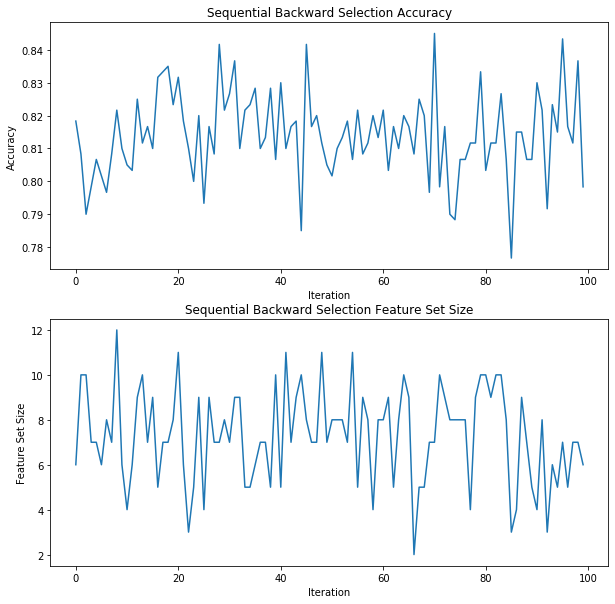

In [19]:
fig, axs= plt.subplots(2, figsize=(10,10))
axs[0].plot(bestFeatures['avg_score'])
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Sequential Backward Selection Accuracy')

axs[1].plot(bestFeatures['feature_count'])
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel('Feature Set Size')
axs[1].set_title('Sequential Backward Selection Feature Set Size')

By looking at the results for each top performing subset we can see that we that we have a high variance of accuracies and feature set sizes. This show the instability of the feature selection process. As with the evaluation methods shown in the previous part, these testing methods rely heavily on the random split in the testing data. Now we can see that it can affect the feature selection process as well.

(0.0, 30.0)

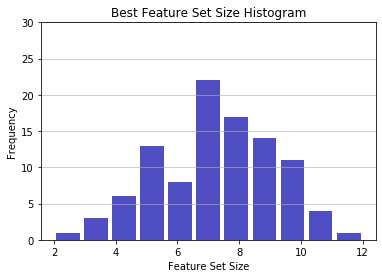

In [20]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=bestFeatures['feature_count'], bins=11, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Feature Set Size')
plt.ylabel('Frequency')
plt.title('Best Feature Set Size Histogram')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

I was curious to see the distribution of feature set sizes, and from this histogram it seems to be a normal distribution. This makes sense as normal distribution come often naturally and is especially prevalent events which are dependent on chance (random split).

We have out best performing feature set. I also want to see which features are most frequent.

In [21]:
#Combine feature lists.
allFeatures = ()
for featureList in bestFeatures['feature_names'].values:
    allFeatures = allFeatures + featureList
    
print("Feature Counts")
print(Counter(allFeatures))
print("\nFeature 'time' was in {:.0%} of the top performing feature sets\n".format( (Counter(allFeatures)['time']/reps_2)))

print("Feature Set Size")
print(Counter(bestFeatures['feature_count'].values))

Feature Counts
Counter({'time': 100, 'ejection_fraction': 74, 'platelets': 74, 'serum_sodium': 73, 'age': 64, 'high_blood_pressure': 54, 'sex': 54, 'anaemia': 53, 'diabetes': 50, 'smoking': 50, 'creatinine_phosphokinase': 47, 'serum_creatinine': 37})

Feature 'time' was in 100% of the top performing feature sets

Feature Set Size
Counter({7: 22, 8: 17, 9: 14, 5: 13, 10: 11, 6: 8, 4: 6, 11: 4, 3: 3, 12: 1, 2: 1})


The feature time was in 100% of the best performing feature sets. This shows possible a dependency of this variable and the classification result, or that there is an collinearity between time and the death result. With this dependency there is a chance that time could cause the model to over-fit the data. There would be merit in removing the time feature and running the process again to see what the resulting feature set and performance will be like without this dominant time feature.  

Now lets look at the most common feature sets

In [22]:
print(Counter(bestFeatures['feature_names'].values).most_common(5))

print("\nThe most common feature set repersented {:.0%} of feature sets of size 7\n".format( (7/22)))

[(('age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction', 'serum_creatinine', 'sex', 'time'), 3), (('age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_sodium', 'sex', 'smoking', 'time'), 3), (('diabetes', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time'), 2), (('diabetes', 'platelets', 'serum_sodium', 'time'), 2), (('platelets', 'serum_sodium', 'time'), 2)]

The most common feature set repersented 32% of feature sets of size 7



The most common feature set only represents 3% of the whole top feature sets, and only a third of in its feature set size category. It is also different to our top performing feature set. This again shows the massive variance and instability of feature selection.  

### Testing with Selected Features
From the previous stage I have identified 3 different feature sets.

**Best Feature set:**
Selected by taking the best performing feature set.

*('age', 'anaemia', 'platelets', 'serum_sodium', 'sex', 'smoking', 'time')*


**Most common feature set:**
Selected by counting all top performing feature sets, and finding the most frequent

*('age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction', 'serum_creatinine', 'sex', 'time')*

**Most common features, limited by the most common feature set size (7):**
Selecting the n most frequent features in top performing feature sets, where n is the most common feature set size.
You could suggest that this method is similar to the Filter k Best Feature Selection method. However we have used Backwards Sequential Elimination to find frequent subsets rather than individually testing the features themselves.  

*('time', 'ejection_fraction', 'platelets', 'serum_sodium', 'age', 'high_blood_pressure', 'sex')*

With these I will run a hold-out testing on our heart test data, and see if the feature selection has effected the performance of the model. 

In [23]:
heart_test = pd.read_csv('heart-test.csv')
heart_test.head(10) 
y = heart_test.pop('DEATH_EVENT').values

In [24]:
#Features Sets
best_featureSet = ['age', 'anaemia', 'platelets', 'serum_sodium', 'sex', 'smoking', 'time']

mc_featureSet = ['age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction', 
                 'serum_creatinine', 'sex', 'time']

mc_features = ['time', 'ejection_fraction', 'platelets', 'serum_sodium', 
               'age', 'high_blood_pressure', 'sex']

test_featureSelections = ["allFeatures", "topFeatureSet", "topFeatures"]

#Have a dictionary to hold all of the data (X), and the results
X = heart_test.values
df_bestFeatureSet = heart_test[best_featureSet]
X_bestFeatureSet = df_bestFeatureSet.values
df_featureSet = heart_test[mc_featureSet]
X_featureSet = df_featureSet.values
df_features = heart_test[mc_features]
X_feature = df_features.values


featureSelections = {
    "allFeatures": {
        "df": heart_test,
        "X": X
    },
    
    "topFeatureSet": {
        "df": df_bestFeatureSet,
        "X": X_bestFeatureSet
    },
    
    "commonFeatureSet": {
        "df": df_featureSet,
        "X": X_featureSet
    },
    
    "topFeatures": {
        "df": df_features,
        "X": X_feature
    }
    
}

#Show that features have been removed
print('allFeatures')
print(X.shape)

print('topFeatureSet')
print(X_bestFeatureSet.shape)

print('commonFeatureSet')
print(X_featureSet.shape)

print('topFeatures')
print(X_feature.shape)

allFeatures
(100, 12)
topFeatureSet
(100, 7)
commonFeatureSet
(100, 7)
topFeatures
(100, 7)


### Feature Selection Performance 1 Rep
Like with the selection process I will first do 1 rep of testing and evaluating, as this will allow me to include a ROC curve. It will also allow me to compare the 1 rep results with the average results so again showcase the difference in performance when using different random_states.

In [25]:
for selection in featureSelections:
    X_train, X_test, y_train, y_test = train_test_split(featureSelections[selection]['X'], y, random_state=42)
    
    featureSelections[selection]["X_train"] = X_train
    featureSelections[selection]["X_test"] = X_test
    featureSelections[selection]["y_train"] = y_train
    featureSelections[selection]["y_test"] = y_test
    
    #Train + Prediction Results
    model = gradBoost.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #ROC
    y_score = gradBoost.predict_proba(X_test)
    featureSelections[selection]["roc"] = y_score
    #Accuracy
    acc = accuracy_score(y_test, y_pred)
    featureSelections[selection]["acc"] = acc
    #F-1 Score
    f1 = f1_score(y_test, y_pred)
    featureSelections[selection]["f1"] = acc

    print("{:20}\tAccuracy: {:.3f}\t F1-Score: {:.3f}".format(
                                                selection, 
                                                acc,
                                                f1))

allFeatures         	Accuracy: 0.760	 F1-Score: 0.727
topFeatureSet       	Accuracy: 0.720	 F1-Score: 0.720
commonFeatureSet    	Accuracy: 0.760	 F1-Score: 0.727
topFeatures         	Accuracy: 0.800	 F1-Score: 0.783


From these we can see that the top selected features has generated the best model (in terms of performance in accuracy and F1-score). The top feature selection has resulting in a model with high accuracy while also having a high rate of classifiying the positive case correctly and frequently. 

Surprisingly the top feature set (which was the feature set which has the best accuracy in the training set) has had an worse performance than using all the features. This suggest that this feature set over-fitted to the training data, and now has under performed in the test data. This again shows the instability of feature selection, and that using and comparing different selections is the best method of finding the best feature sets. 

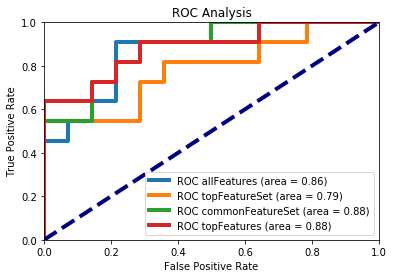

In [26]:
from sklearn.metrics import roc_curve, auc
#Plot ROC curves
def plotROC(featureSelections):
    plt.figure()
    lw = 4
    for selection in featureSelections:
        y_test = featureSelections[selection]["y_test"]
        rocProb = featureSelections[selection]["roc"]
        fprX, tprX, t = roc_curve(y_test, rocProb[:,1])
        roc_aucX = auc(fprX, tprX)
        label = 'ROC {:10} (area = {:.2f})'.format(selection, roc_aucX)
        plt.plot(fprX, tprX, lw=lw, label=label)

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Analysis')
    plt.legend(loc="lower right")
    plt.show()
    
    
plotROC(featureSelections)

By looking at the ROC curve we can again see that the top feature set has performed the worse out of all the feature selection methods. By looking the all feature line (blue), we can see for a certain threshold (~0.3) using all the features was the better model. This shows that the original feature set was a good dataset for classifying the model.

However by removing features we have increased the storage required to hold the dataset, and have improved the computation power needed. As we have shown removing features can also result in a better performance as well. 

### Feature Selection Performance Multiple Reps
I will see which feature selection on average performed best, and to see if there is instability in the results.

In [27]:
reps = 100

for i in range(reps):
    for selection in featureSelections:

        X_train, X_test, y_train, y_test = train_test_split(featureSelections[selection]["X"], y, random_state=i)
        
        #Train + Prediction Results
        model = gradBoost.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        #Accuracy
        acc = accuracy_score(y_test, y_pred)

        #F-1 Score
        f1 = f1_score(y_test, y_pred)  
        
        if i is 0:
            featureSelections[selection]["reps_acc"] = [acc]
            featureSelections[selection]["reps_f1"] = [f1]
        else:
            featureSelections[selection]["reps_acc"].append(acc)
            featureSelections[selection]["reps_f1"].append(f1)

In [28]:
for selection in featureSelections:
    print("{:10}:\n\tAverage Performace\tAccuracy: {:.3f}\t F1-Score: {:.3f}".format(
                                                selection,
                                                statistics.mean(featureSelections[selection]["reps_acc"]),
                                                statistics.mean(featureSelections[selection]["reps_f1"])))
    print("\tStandard Deviation\tAccuracy: {:.3f}\t F1-Score: {:.3f}".format(
                                                statistics.stdev(featureSelections[selection]["reps_acc"]),
                                                statistics.stdev(featureSelections[selection]["reps_f1"])))

allFeatures:
	Average Performace	Accuracy: 0.819	 F1-Score: 0.709
	Standard Deviation	Accuracy: 0.070	 F1-Score: 0.114
topFeatureSet:
	Average Performace	Accuracy: 0.803	 F1-Score: 0.659
	Standard Deviation	Accuracy: 0.066	 F1-Score: 0.131
commonFeatureSet:
	Average Performace	Accuracy: 0.836	 F1-Score: 0.726
	Standard Deviation	Accuracy: 0.067	 F1-Score: 0.116
topFeatures:
	Average Performace	Accuracy: 0.831	 F1-Score: 0.719
	Standard Deviation	Accuracy: 0.071	 F1-Score: 0.128


On average we can see that using the most common feature set resulted in the best accuracy. It also had a low standard deviation, such suggesting that it is also the most stable method of selecting features. This can be due to the fact that it was the most common best performing feature set, and thus it performed best in many different training datasets.

You can suggest that the selection the most common features is the most unstable method as it as the highest standard deviation. You could further suggest that this shows that the feature selection process of filtering for top features is an unstable method of feature selection. This could be due to the high variance of results which comes from the training data splitting, and thus the best features for that split will be different.

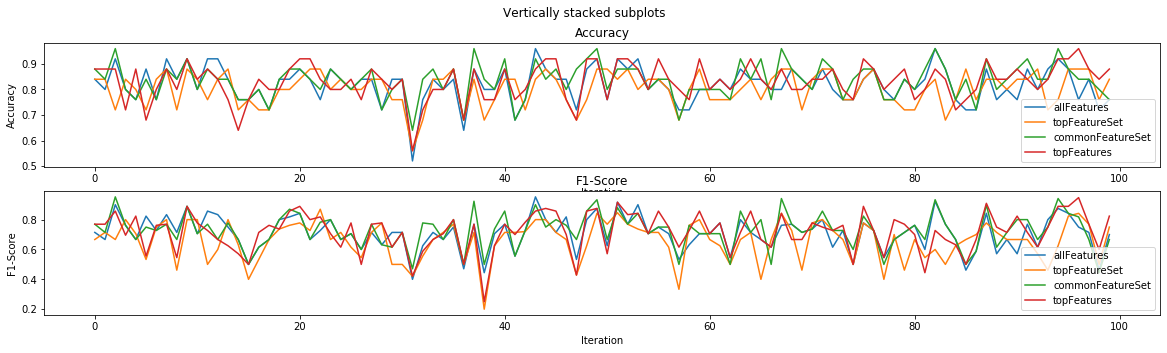

In [29]:
fig, axs = plt.subplots(2, figsize=(20,5))
fig.suptitle('Vertically stacked subplots')

for selection in featureSelections:
    axs[0].plot(featureSelections[selection]["reps_acc"], label=selection)
    axs[1].plot(featureSelections[selection]["reps_f1"], label=selection)


      
axs[0].legend(loc="lower right")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Accuracy")

axs[1].legend(loc="lower right")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("F1-Score")
axs[1].set_title("F1-Score")
plt.show()

These chart visually show the instability of the results. However as we have proven in the previous part, this instability is due to the random_split in the evaluation process, and it was especially high by using hold out testing (which is used in these charts). Thus this instability shown here is a combination of both the feature selection and the testing method. 

These instabilities come from the same source however, as again they are connected to the luckiness of the random split in the training data. Therefore we will not see any improvement in the stability of both the testing or feature selection until we have a method of removing this dependency of the random_split. In the mean time we can use methods which reduce this instability such as using cross validation instead of hold-out testing. For improving stability in feature selection is could be using Backwards Sequential Elimination and finding the most common best performing feature sets, as these collection of features have performed best for different training data splits.